In [77]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
# 1. Load and prepare data
df = pd.read_csv(r'D:\Machine-Learning\ECG-Based Arrhythmia Detection\Preprocessing\ECG_AFter_PCA.csv')  # Your balanced dataset


In [79]:
df_filtered = df.query("target not in [4, 5, 10,6,12]")

In [80]:
X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

In [81]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [82]:
# 3. Feature scaling (optional for Random Forest but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [83]:
# 4. Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    max_depth=10,           # Maximum tree depth
    min_samples_split=5,    # Minimum samples to split node
    class_weight='balanced', # Handles residual imbalance
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [84]:
# 5. Predictions
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)  # For probability outputs

In [85]:
# 6. Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.83      0.62      0.71        16
           7       0.00      0.00      0.00         2
           8       0.80      0.99      0.88        74
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.81       103
   macro avg       0.20      0.20      0.20       103
weighted avg       0.71      0.81      0.75       103




Confusion Matrix:


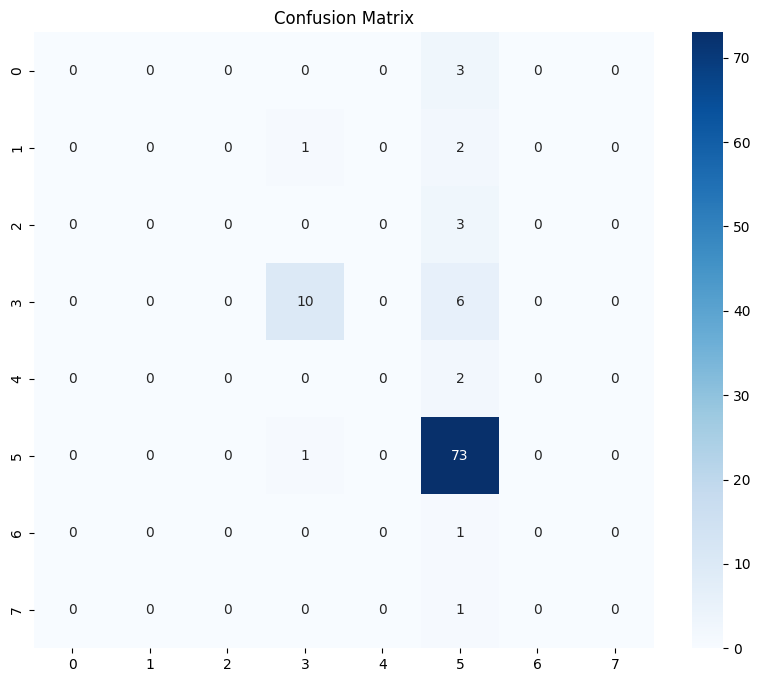

In [86]:
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [88]:
# Assume cm is your confusion matrix (N x N for N classes)
n_classes = [0,1,2,3,7,8,9,13]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(len(n_classes)):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {n_classes[i]}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")


Class 0: Sensitivity = 0.0000, Specificity = 1.0000
Class 1: Sensitivity = 0.0000, Specificity = 1.0000
Class 2: Sensitivity = 0.0000, Specificity = 1.0000
Class 3: Sensitivity = 0.6250, Specificity = 0.9770
Class 7: Sensitivity = 0.0000, Specificity = 1.0000
Class 8: Sensitivity = 0.9865, Specificity = 0.3793
Class 9: Sensitivity = 0.0000, Specificity = 1.0000
Class 13: Sensitivity = 0.0000, Specificity = 1.0000


In [89]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.8058 (80.58%)


c:\Users\DARSHAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


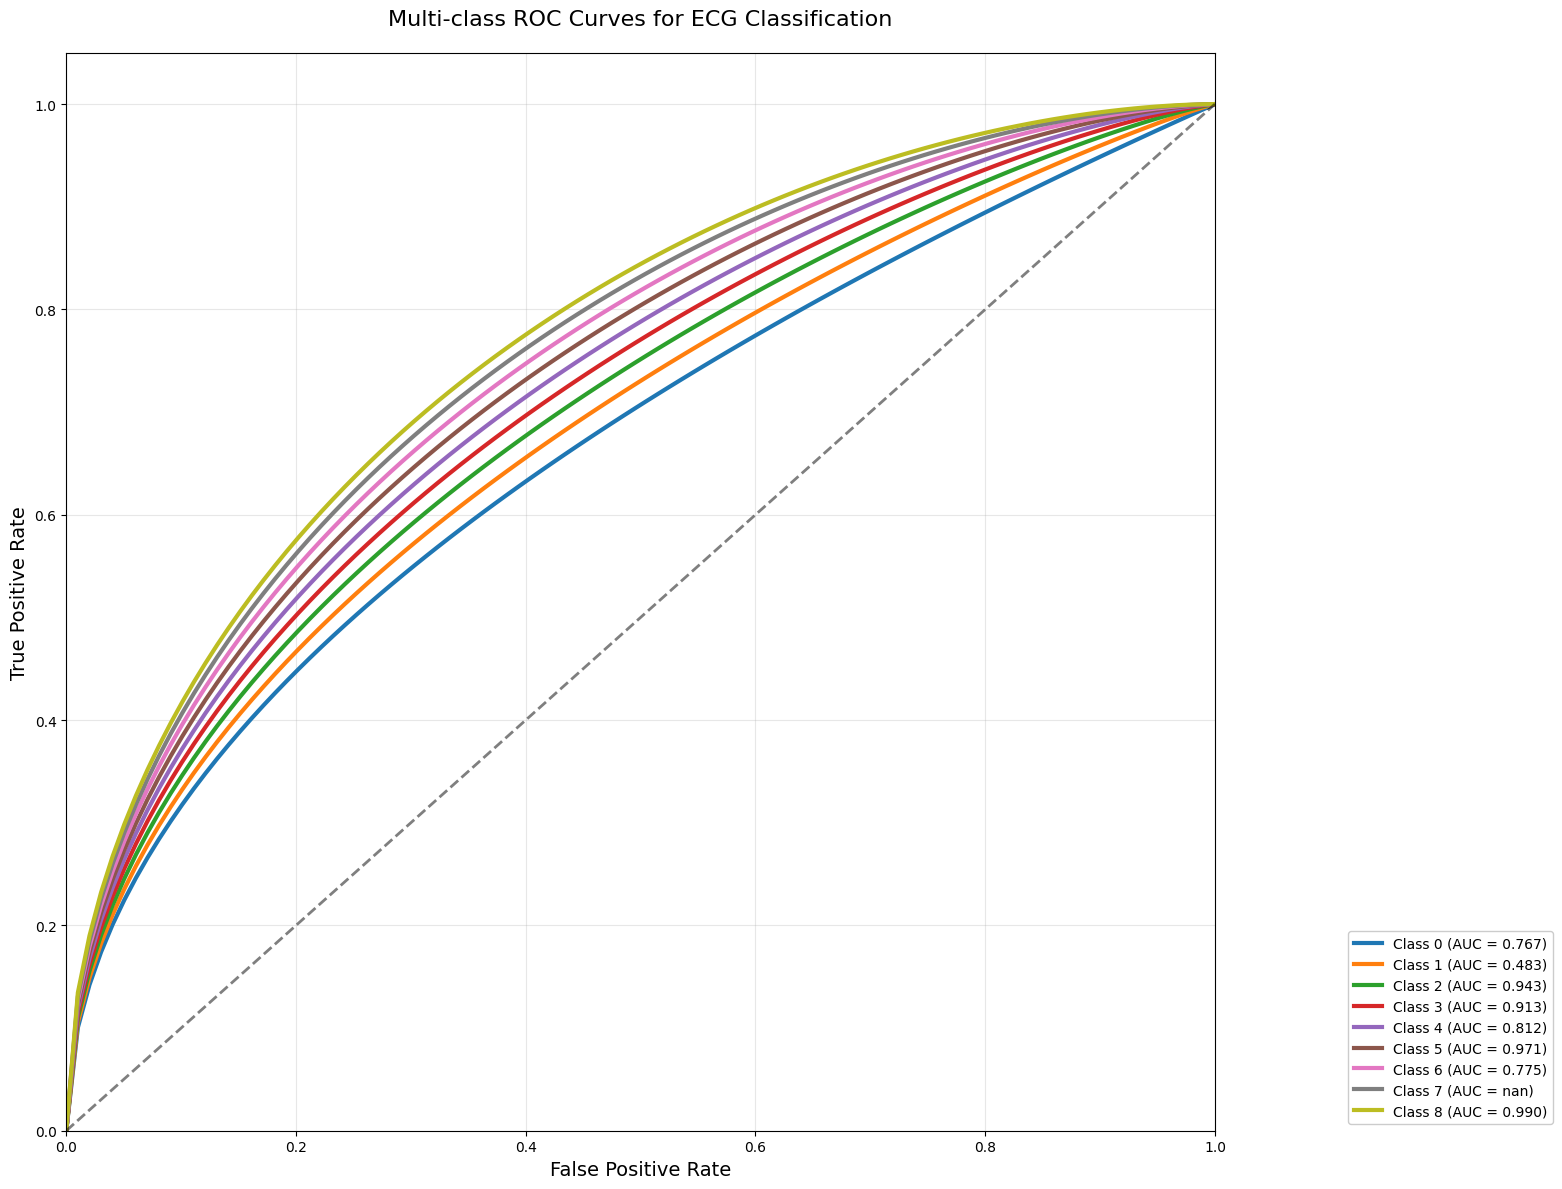

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Balanced Multiclass**

In [91]:
# 1. Load and prepare data
df = pd.read_csv(r'D:\Machine-Learning\ECG-Based Arrhythmia Detection\Multiclass_Classification\balanced_ecg_data.csv')  # Your balanced dataset
X = df.drop('target', axis=1)
y = df['target']

In [92]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Preserve class distribution
)

In [93]:
# 3. Feature scaling (optional for Random Forest but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [94]:
# 4. Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    max_depth=10,           # Maximum tree depth
    min_samples_split=5,    # Minimum samples to split node
    class_weight='balanced', # Handles residual imbalance
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [95]:
# 5. Predictions
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)  # For probability outputs

In [96]:
# 6. Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        73
           1       0.97      1.00      0.99        73
           2       0.97      0.93      0.95        73
           3       0.97      0.96      0.97        74
           4       1.00      1.00      1.00        74
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        74
           7       0.99      1.00      0.99        74
           8       1.00      0.92      0.96        73
           9       0.99      1.00      0.99        73
          10       1.00      1.00      1.00        74
          11       1.00      1.00      1.00        73
          12       1.00      1.00      1.00        73
          13       1.00      1.00      1.00        74

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028




Confusion Matrix:


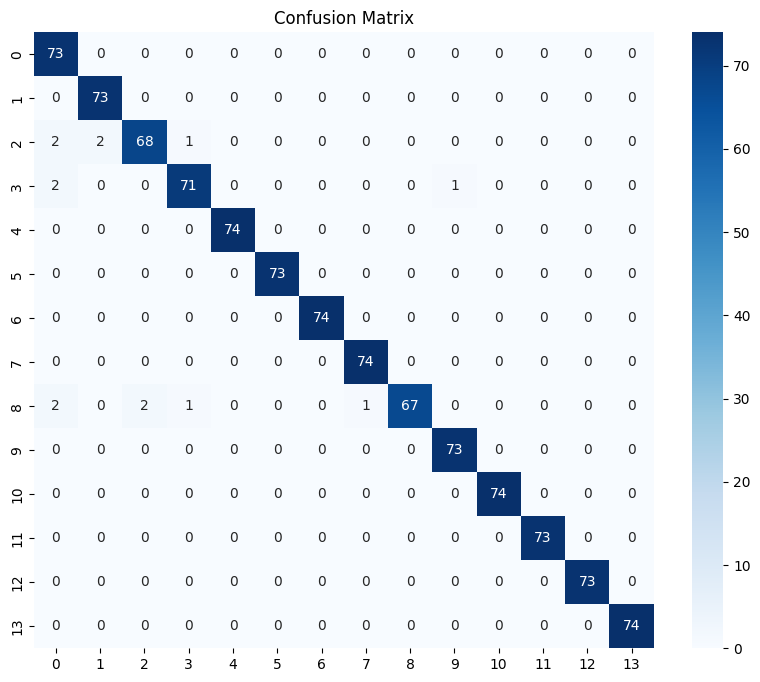

In [97]:
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [98]:
# Assume cm is your confusion matrix (N x N for N classes)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")


Class 0: Sensitivity = 1.0000, Specificity = 0.9937
Class 1: Sensitivity = 1.0000, Specificity = 0.9979
Class 2: Sensitivity = 0.9315, Specificity = 0.9979
Class 3: Sensitivity = 0.9595, Specificity = 0.9979
Class 4: Sensitivity = 1.0000, Specificity = 1.0000
Class 5: Sensitivity = 1.0000, Specificity = 1.0000
Class 6: Sensitivity = 1.0000, Specificity = 1.0000
Class 7: Sensitivity = 1.0000, Specificity = 0.9990
Class 8: Sensitivity = 0.9178, Specificity = 1.0000
Class 9: Sensitivity = 1.0000, Specificity = 0.9990
Class 10: Sensitivity = 1.0000, Specificity = 1.0000
Class 11: Sensitivity = 1.0000, Specificity = 1.0000
Class 12: Sensitivity = 1.0000, Specificity = 1.0000
Class 13: Sensitivity = 1.0000, Specificity = 1.0000


In [99]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.9864 (98.64%)


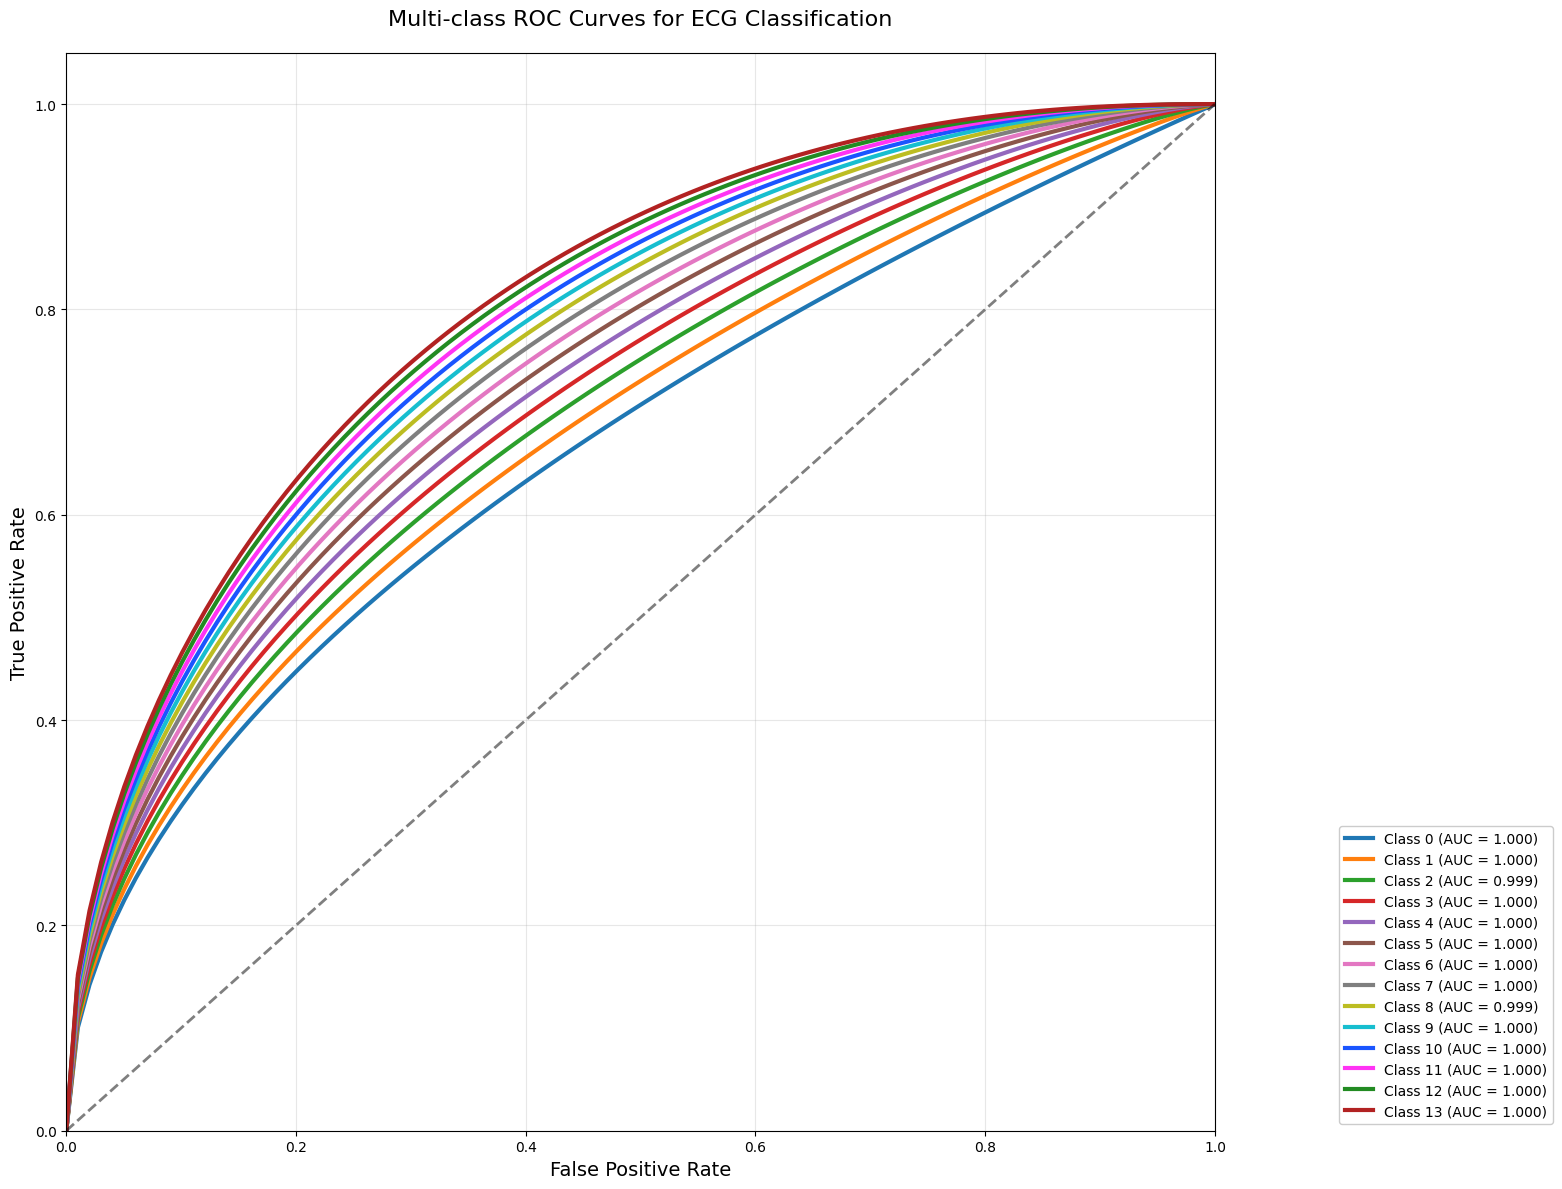

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()